In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import seaborn as sns


We are using the vic pet registration data here:
https://www.kaggle.com/puppygogo/sa-dog-ownership-sample/version/4?#_=_

And for house price data we're going to use the data here:
https://www.kaggle.com/ruizjme/realestate-vic-sold

Finally we got a list of Melbourne suburbs to tell the difference between city and country dogs

In [2]:
df = pd.read_csv('Registrations_Master_Vic.csv')
postcodes = pd.read_csv('ARPC_Postcodes.csv')
melbsuburbs = pd.read_csv('MelbourneSuburbs.csv', header = None).T
melbsuburbs.columns = ['Suburb']
houseprice = pd.read_csv('vichouseprice.csv')

C:\Users\chris\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Lets have a look at our raw data
We can see that most of the columns look pretty good. We have a significant number of missing postcodes, which means we'll use the suburb name for some analysis. Breed, colour and name all seem to have complete data. 

In [3]:
df.head()

,State,Region,Reference,Animal_Type,Animal_Name,Breed_Description_primary,Breed_Description_secondary,Status_Description,Suburb,Postcode,...,Gender,Colour_primary,Colour_secondary,Animal_Desexed,Animal Date of Birth,Age,Microchipped,Registered,latitude,longitude
0,Victoria,Golden Plains,19344.0,DOG,NEKEYTA,HUSKY,NaN,CATEGORY 2,BANNOCKBURN,3331.0,...,F,GREY & WHITE,NaN,Y,NaN,NaN,Y,NaN,-38.046528,144.171067
1,Victoria,Golden Plains,19350.0,DOG,CHIEF,HUSKY,NaN,CATEGORY 2,BANNOCKBURN,3331.0,...,M,BLACK/WHITE,NaN,Y,NaN,NaN,Y,NaN,-38.046528,144.171067
2,Victoria,Golden Plains,7954.0,DOG,BUNDI,JACK RUSSELL TERRIER,NaN,CATEGORY 1,BANNOCKBURN,3331.0,...,M,TAN/WHITE,NaN,N,NaN,NaN,N,NaN,-38.046528,144.171067
3,Victoria,Golden Plains,40335.0,DOG,BOSSY,BULL TERRIER,NaN,CATEGORY 1,BANNOCKBURN,3331.0,...,M,TRI,NaN,N,NaN,NaN,N,NaN,-38.046528,144.171067
4,Victoria,Golden Plains,4689.0,CAT,KINKY,CROSS BREED CAT,NaN,CATEGORY 2,BANNOCKBURN,3331.0,...,M,WHITE,NaN,Y,NaN,NaN,Y,NaN,-38.046528,144.171067


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158026 entries, 0 to 158025
Data columns (total 21 columns):
State                          158026 non-null object
Region                         158026 non-null object
Reference                      13646 non-null float64
Animal_Type                    158026 non-null object
Animal_Name                    111706 non-null object
Breed_Description_primary      154833 non-null object
Breed_Description_secondary    209 non-null object
Status_Description             10509 non-null object
Suburb                         157953 non-null object
Postcode                       62137 non-null float64
Year                           0 non-null float64
Gender                         19180 non-null object
Colour_primary                 153806 non-null object
Colour_secondary               2459 non-null object
Animal_Desexed                 25790 non-null object
Animal Date of Birth           4095 non-null float64
Age                            88971 n

In [5]:
df.Animal_Type.unique()

array(['DOG ', 'CAT ', 'Cat                                     ',
       'Dog                                     ', 'Dog', 'Cat', 'dog',
       'cat', 'Dog       ', 'Cat       '], dtype=object)

### Clearly we need to do some clean-up on the data
We're going to split and rejoin the data to remove all the random extra spaces we can see (particularly in animal type). We're also going to try to have a consistant naming convention for cross-breeds, and remove terrier from breed descriptions so that we can accurately group "Jack Russell" and "Jack Russell Terrier" as the same type of dog. 

In [6]:
df.Animal_Type = df.Animal_Type.apply(lambda x: ''.join(str(x).split()).lower())
df.Suburb = df.Suburb.apply(lambda x: ' '.join(str(x).split()).lower())
df.Breed_Description_primary = df.Breed_Description_primary.apply(lambda x: ' '.join(str(x).split()).lower())
df.Breed_Description_primary = df.Breed_Description_primary.apply(lambda x: x.replace('(cross)', 'x'))
df.Breed_Description_primary = df.Breed_Description_primary.apply(lambda x: x.replace('cross', 'x'))
df.Animal_Name = df.Animal_Name.apply(lambda x: ' '.join(str(x).split()).lower())
df.Breed_Description_primary = df.Breed_Description_primary.apply(lambda x: x.replace('terrier', ''))
df.Breed_Description_primary = df.Breed_Description_primary.apply(lambda x: ' '.join(str(x).split()).lower())

df.Colour_primary = df.Colour_primary.apply(lambda x: ' '.join(str(x).split()).lower())
df['pure_breed'] = (df.Breed_Description_primary.apply(lambda x: 'x' not in x)) & (df.Breed_Description_secondary.isna())

melbsuburbs.Suburb = melbsuburbs.Suburb.apply(lambda x: ' '.join(str(x).split()).lower())
melbsuburbs['Melbourne'] = True


### House price data
We're going to use the house price data to get an average price per suburb. We'll apply similar cleaning techniques, then some grouping to get this data

In [7]:
houseprice.suburb = houseprice.suburb.apply(lambda x: ' '.join(str(x).split()).lower())
houseprice.price = pd.to_numeric(houseprice.price.apply(lambda x: x.strip('$').replace(',','')), errors = 'coerce')
houseprice.groupby('suburb').mean()
housepriceavg = houseprice.groupby('suburb').median()

We're going to merge the data with our "suburbs in Melbourne" data to see if there are any noticable differences between city and country dogs.

We're also going to merge with house prices to find correlations between breed and affluence

In [8]:
df = df.merge(melbsuburbs, on ='Suburb', how = 'left')
df['Melbourne'] = df['Melbourne'].fillna(False)
df = df.merge(housepriceavg, left_on='Suburb', right_on='suburb', how = 'left')


# Cleaned Dataset
Let's have a look at our fancy new clean data-set

In [9]:
df.head()

,State,Region,Reference,Animal_Type,Animal_Name,Breed_Description_primary,Breed_Description_secondary,Status_Description,Suburb,Postcode,...,pure_breed,Melbourne,latitude_y,longitude_y,postcode,bedrooms,bathrooms,parkingSpaces,price,listingId
0,Victoria,Golden Plains,19344.0,dog,nekeyta,husky,NaN,CATEGORY 2,bannockburn,3331.0,...,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Victoria,Golden Plains,19350.0,dog,chief,husky,NaN,CATEGORY 2,bannockburn,3331.0,...,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Victoria,Golden Plains,7954.0,dog,bundi,jack russell,NaN,CATEGORY 1,bannockburn,3331.0,...,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Victoria,Golden Plains,40335.0,dog,bossy,bull,NaN,CATEGORY 1,bannockburn,3331.0,...,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Victoria,Golden Plains,4689.0,cat,kinky,x breed cat,NaN,CATEGORY 2,bannockburn,3331.0,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def chrisbarplot(series, x=10):
    names, count = np.unique(series, return_counts=True)
    df = pd.DataFrame(
        data = {'label': names, 'value': count},
        ).sort_values('value', ascending = False)

    df2 = df[:x].copy()

    #others
    new_row = pd.DataFrame(data = {
        'label' : ['others'],
        'value' : [df['value'][x:].sum()]
    })

    #combining top 5 with others
    df2 = pd.concat([df2, new_row])
    y_pos = np.arange(len(df.value))
    ax = sns.barplot(x='label', y='value', data = df2)
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    ax.set(xlabel='', ylabel='Number')

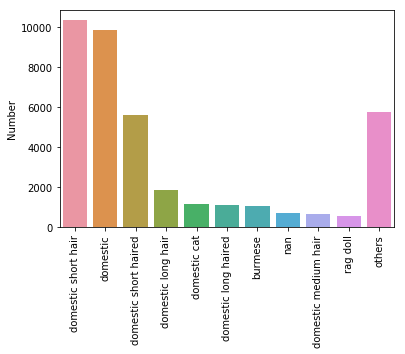

In [11]:
chrisbarplot(df.Breed_Description_primary[df.Animal_Type=='cat'])

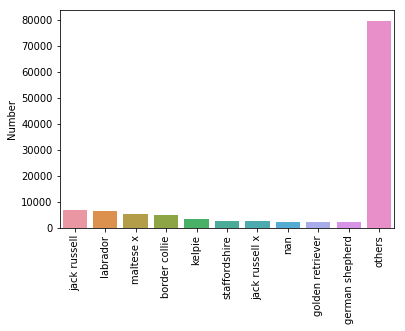

In [12]:
chrisbarplot(df.Breed_Description_primary[(df.Animal_Type=='dog')])

[Text(0,0.5,'Difference between Melbourne and Regional \n(lower indicates more likely to be found in regional VIC)'),
 Text(0.5,0,'Breed')]

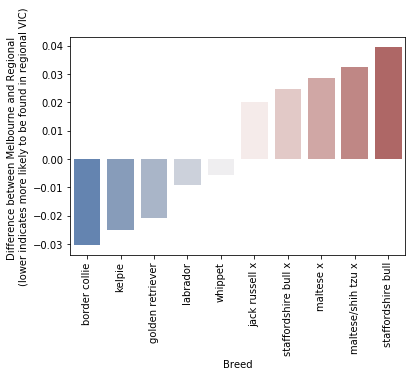

In [13]:

def ratiocalc(series):
    names, count = np.unique(series, return_counts=True)
    ratio = pd.DataFrame(
            data = {'label': names, 'value': count},
            )
    ratio.value = ratio.value/(series.shape)
    return ratio

melbbreeds = ratiocalc(df[(df.Animal_Type=='dog') & (df.Melbourne == True)]['Breed_Description_primary'])
ruralbreeds = ratiocalc(df[(df.Animal_Type=='dog') & (df.Melbourne == False)]['Breed_Description_primary'])
ruralbreeds

breedcompare = melbbreeds.merge(ruralbreeds, on = 'label')
breedcompare['diff'] = breedcompare.value_x - breedcompare.value_y
breedcompare = breedcompare.sort_values('diff')

breed_top_bottom = pd.concat([breedcompare[0:5], breedcompare[-5:]])
breed_top_bottom
#breedcompare
ax = sns.barplot(x='label', y='diff', palette="vlag", data = breed_top_bottom)
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.set(xlabel = "Breed", ylabel = "Difference between Melbourne and Regional \n(lower indicates more likely to be found in regional VIC)")

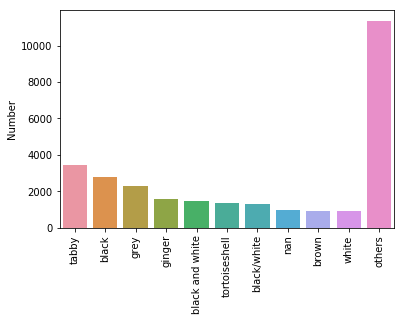

In [14]:
chrisbarplot(df.Colour_primary[(df.Animal_Type=='cat') & (df.Melbourne == False)])

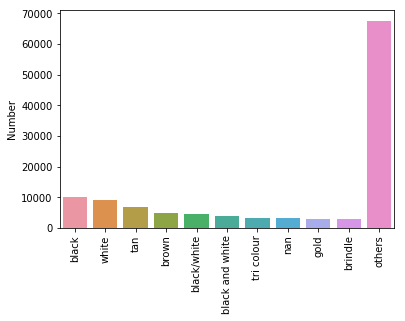

In [15]:
chrisbarplot(df.Colour_primary[df.Animal_Type=='dog'])

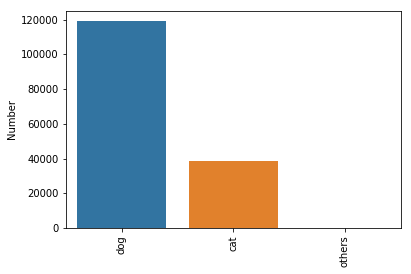

In [16]:
chrisbarplot(df.Animal_Type)

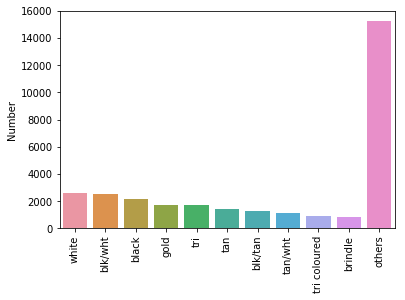

In [17]:
chrisbarplot(df.Colour_primary[(df.Animal_Type=='dog') & (df.Melbourne == True)])

In [18]:
df[df.Animal_Type=='cat'].Age.describe()

count    22805.000000
mean         8.432098
std          5.637348
min          0.000000
25%          4.000000
50%          8.000000
75%         12.000000
max         71.000000
Name: Age, dtype: float64

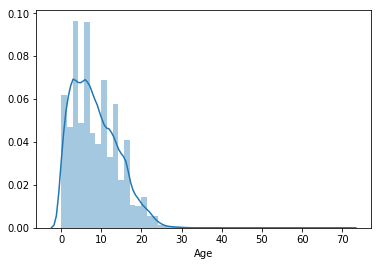

In [19]:
sns.distplot(df[df.Animal_Type=='cat'].Age.dropna())

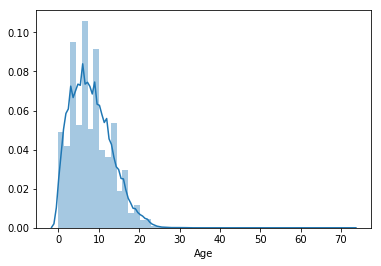

In [20]:
sns.distplot(df[df.Animal_Type=='dog'].Age.dropna())

# Calculating the most common breeds in a suburb
We want to do a bit of aggregation to discover the most common breed in each suburb We're going to add this data to our house price data to draw some trends

In [21]:
commonbreed = df[df.Animal_Type=='dog'].groupby(['Suburb']).agg(lambda x:x['Breed_Description_primary'].value_counts().index[0])['Breed_Description_primary']
pure_breed_percent = df[df.Animal_Type=='dog'].groupby(['Suburb']).mean()['pure_breed']
dog_count = df[df.Animal_Type=='dog'].groupby(['Suburb']).count()['State']
dog_count.head()

Suburb
addington         25
aireys inlet     180
alfredton       2218
alvie             37
anakie           139
Name: State, dtype: int64

In [22]:
housepriceavg['common_breed']=commonbreed
housepriceavg['pure_breed'] = pure_breed_percent
housepriceavg['dog_count'] = dog_count

In [23]:
housepriceavg = housepriceavg.dropna().sort_values(by = 'price', ascending = False)

# Let's look at our new house price data with additional columns

In [24]:
housepriceavg.head()

,latitude,longitude,postcode,bedrooms,bathrooms,parkingSpaces,price,listingId,common_breed,pure_breed,dog_count
suburb,,,,,,,,,,,
barwon downs,-38.468454,143.778366,3243.0,3.0,1.0,2.0,1500000.0,7989582.0,kelpie,0.787879,33.0
barwon heads,-38.275751,144.488979,3227.0,3.0,2.0,2.0,1127500.0,129393508.0,labrador,0.825000,680.0
bonshaw,-37.599983,143.807690,3352.0,4.0,3.0,12.0,1010000.0,128849946.0,jack russell,0.563380,71.0
moolap,-38.177077,144.430089,3224.0,4.0,2.0,6.0,960000.0,129422274.0,labrador,0.778878,303.0
anakie,-37.986431,144.248332,3213.0,4.0,2.0,4.0,955000.0,129463322.0,kelpie,0.748201,139.0


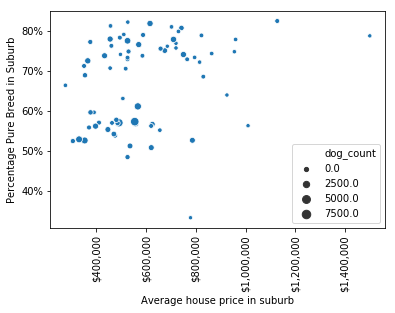

In [25]:
ax = sns.scatterplot(x = 'price', y = 'pure_breed', size='dog_count', data = housepriceavg)
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
ax.set(xlabel='Average house price in suburb', ylabel='Percentage Pure Breed in Suburb')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{0:.0f}%".format(x * 100)))
for item in ax.get_xticklabels():
    item.set_rotation(90)

In [26]:
breed_price = housepriceavg.groupby('common_breed').mean()['price'].sort_values(ascending = False)

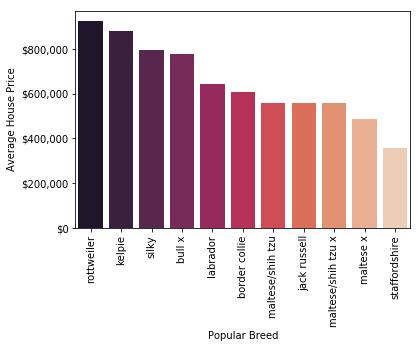

In [27]:
ax = sns.barplot(x=breed_price.index, y=breed_price.values, palette="rocket")
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.set(xlabel='Popular Breed', ylabel='Average House Price')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))